In [1]:
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import lightgbm as lgb
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv('../data/raw/Train.csv')
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
data = data.replace(-1, np.nan) # Null values in this dataset are set as -1
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   594996 non-null  float64
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595129 non-null  float64
 6   ps_ind_05_cat   589403 non-null  float64
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [4]:
data_train, data_val = train_test_split(data, test_size=0.1, random_state=13)

In [5]:
data_train.isna().sum()

id                     0
target                 0
ps_ind_01              0
ps_ind_02_cat        199
ps_ind_03              0
ps_ind_04_cat         77
ps_ind_05_cat       5256
ps_ind_06_bin          0
ps_ind_07_bin          0
ps_ind_08_bin          0
ps_ind_09_bin          0
ps_ind_10_bin          0
ps_ind_11_bin          0
ps_ind_12_bin          0
ps_ind_13_bin          0
ps_ind_14              0
ps_ind_15              0
ps_ind_16_bin          0
ps_ind_17_bin          0
ps_ind_18_bin          0
ps_reg_01              0
ps_reg_02              0
ps_reg_03          96915
ps_car_01_cat        100
ps_car_02_cat          5
ps_car_03_cat     369921
ps_car_04_cat          0
ps_car_05_cat     239745
ps_car_06_cat          0
ps_car_07_cat      10381
ps_car_08_cat          0
ps_car_09_cat        511
ps_car_10_cat          0
ps_car_11_cat          0
ps_car_11              5
ps_car_12              1
ps_car_13              0
ps_car_14          38385
ps_car_15              0
ps_calc_01             0


## Data cleaning

- Categorical features: Imputed with the mode. Initially tested missing indicators and special value flags, but they didn't improve model performance, so they were dropped.
- Numerical features: Imputed with the median.

In [6]:
data_train, data_val = train_test_split(data, test_size=0.1, random_state=13)
# To avoid data leakage and have unseen data, we get a validation set seperate from the train set

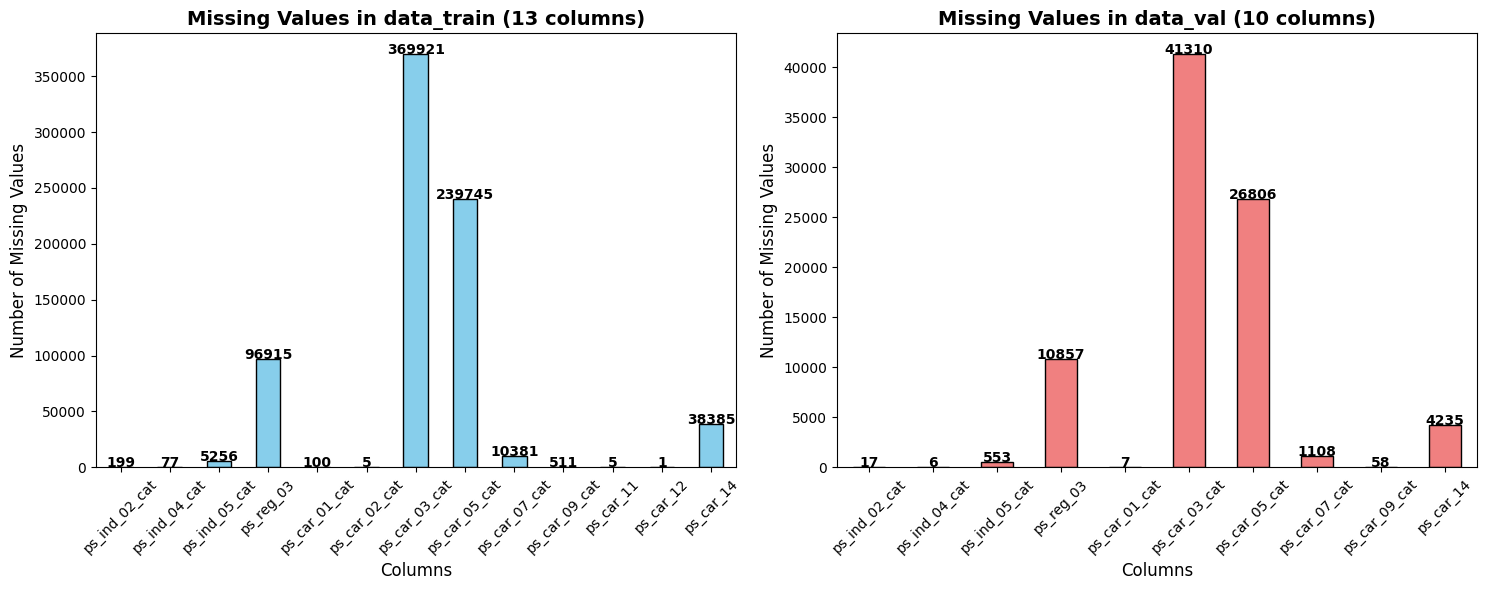

In [7]:
train_missing = data_train.isnull().sum()
val_missing = data_val.isnull().sum()

train_missing_with_data = train_missing[train_missing > 0]
val_missing_with_data = val_missing[val_missing > 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

if len(train_missing_with_data) > 0:
    train_missing_with_data.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
    ax1.set_title(f'Missing Values in data_train ({len(train_missing_with_data)} columns)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Columns', fontsize=12)
    ax1.set_ylabel('Number of Missing Values', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(train_missing_with_data):
        ax1.text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold')
else:
    ax1.text(0.5, 0.5, 'No missing values in data_train', 
             ha='center', va='center', transform=ax1.transAxes, fontsize=14)
    ax1.set_title('Missing Values in data_train', fontsize=14, fontweight='bold')

if len(val_missing_with_data) > 0:
    val_missing_with_data.plot(kind='bar', ax=ax2, color='lightcoral', edgecolor='black')
    ax2.set_title(f'Missing Values in data_val ({len(val_missing_with_data)} columns)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Columns', fontsize=12)
    ax2.set_ylabel('Number of Missing Values', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(val_missing_with_data):
        ax2.text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'No missing values in data_val', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=14)
    ax2.set_title('Missing Values in data_val', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
data_train = data_train.drop('id', axis=1)
data_val = data_val.drop('id', axis=1)

In [9]:
cols_fillna_mode = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_02_cat']
for col in cols_fillna_mode:
    mode = data_train[col].mode()[0]
    data_train[col] = data_train[col].fillna(mode)
    data_val[col] = data_val[col].fillna(mode)

In [10]:
cols_fillna_median = ['ps_reg_03', 'ps_car_14', 'ps_car_11', 'ps_car_12', ]
for col in cols_fillna_median:
    median = data_train[col].median()
    data_train[col] = data_train[col].fillna(median)
    data_val[col] = data_val[col].fillna(median)

In [11]:
drop_cols = ['ps_car_03_cat', 'ps_car_05_cat', 'ps_ind_11_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_car_07_cat', 
             'ps_car_10_cat', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 
             'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 
             'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
# low importance columns, the 'missing' indicator was not of use.

data_train = data_train.drop(drop_cols, axis=1)
data_val = data_val.drop(drop_cols, axis=1)

In [12]:
if data_train.isna().sum().sum() == 0 and data_val.isna().sum().sum() == 0:
    print("All null values have been handled.")

All null values have been handled.


## Visualizing

- The target variable is highly imbalanced, with claims representing less than 4% of observations. 
- Feature correlations are near zero across the board, indicating minimal linear relationships between variables. 

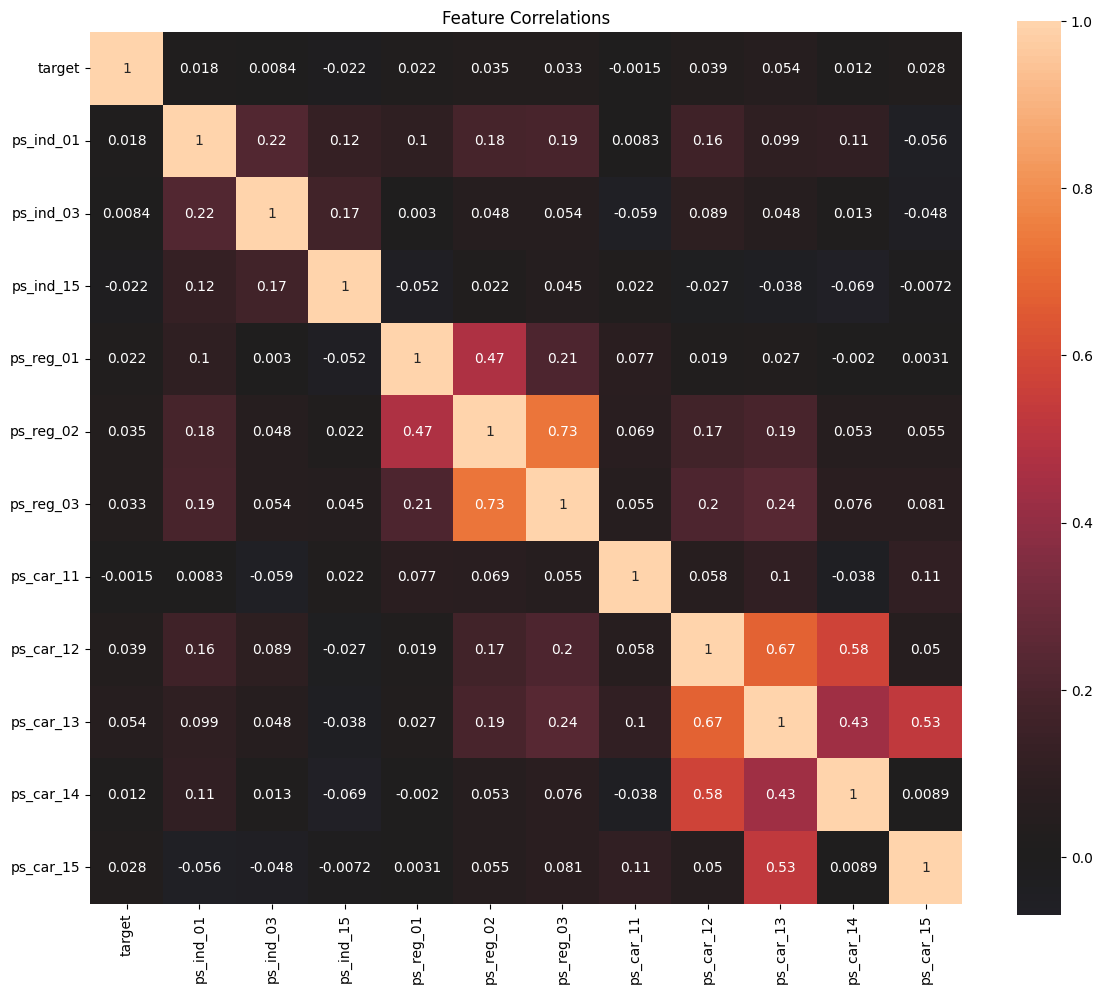

In [13]:
numerical_cols = [c for c in data_train.columns if 'cat' not in c and 'bin' not in c]
plt.figure(figsize=(12, 10))
sns.heatmap(data_train[numerical_cols].corr(), 
            annot=True, 
            center=0,
            square=True)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

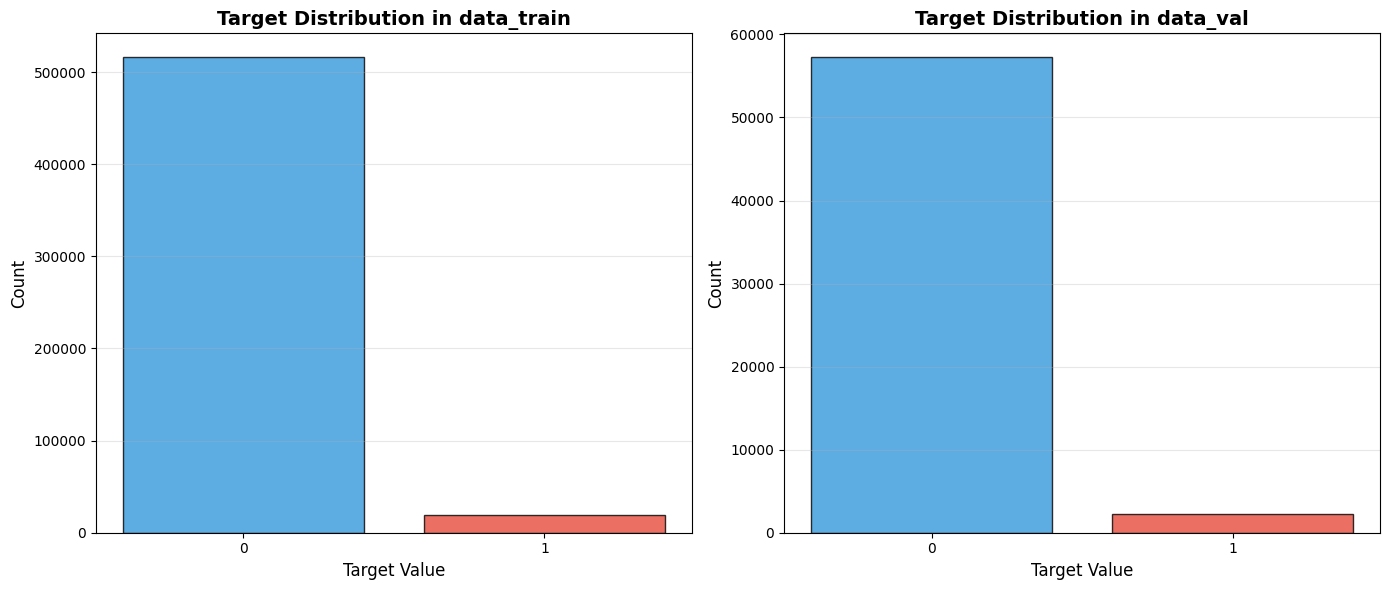

In [14]:
train_target_counts = data_train['target'].value_counts().sort_index()
val_target_counts = data_val['target'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

bar_train = ax1.bar(['0', '1'], 
                [train_target_counts.get(0, 0), train_target_counts.get(1, 0)], 
                color=['#3498db', '#e74c3c'], 
                edgecolor='black', 
                alpha=0.8)
ax1.set_title('Target Distribution in data_train', fontsize=14, fontweight='bold')
ax1.set_xlabel('Target Value', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

bar_val = ax2.bar(['0', '1'], 
                [val_target_counts.get(0, 0), val_target_counts.get(1, 0)], 
                color=['#3498db', '#e74c3c'], 
                edgecolor='black', 
                alpha=0.8)
ax2.set_title('Target Distribution in data_val', fontsize=14, fontweight='bold')
ax2.set_xlabel('Target Value', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Modeling

LightGBM was trained with 1000 trees, a 0.01 learning rate, and 25 leaves. 
5-fold cross-validation was used to generate out-of-fold predictions before final evaluation on the validation set.

- CV Gini: 0.2763
- Validation Gini: 0.2822

In [15]:
X_train = data_train.drop('target', axis=1)
y_train = data_train['target'].values
X_val = data_val.drop('target', axis=1)
y_val = data_val['target'].values

In [16]:
lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'num_leaves': 25,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_samples': 25,
    'force_col_wise': True,
    'random_state': 42
}

In [17]:
lgb_model = lgb.LGBMClassifier(**lgb_params)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
lgb_score_cv = cross_val_predict(lgb_model, X_train, y_train, 
                                 cv=cv, method='predict_proba')[:, 1]

[LightGBM] [Info] Number of positive: 15706, number of negative: 412846
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 428552, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036649 -> initscore=-3.269032
[LightGBM] [Info] Start training from score -3.269032
[LightGBM] [Info] Number of positive: 15427, number of negative: 413125
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 428552, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035998 -> initscore=-3.287631
[LightGBM] [Info] Start training from score -3.287631
[LightGBM] [Info] Number of positive: 15597, number of negative: 412955
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 428552, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036395 -> initscore=-3.276260
[LightGBM] [Info] Start training from score -3.27626

In [18]:
auc = roc_auc_score(y_train, lgb_score_cv)
gini = 2 * auc - 1
gini

0.2763614839659425

In [19]:
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train, y_train)
lgb_score = lgb_model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, lgb_score)
gini = 2 * auc - 1
gini

[LightGBM] [Info] Number of positive: 19437, number of negative: 516253
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 535690, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036284 -> initscore=-3.279418
[LightGBM] [Info] Start training from score -3.279418


0.2822007734718701

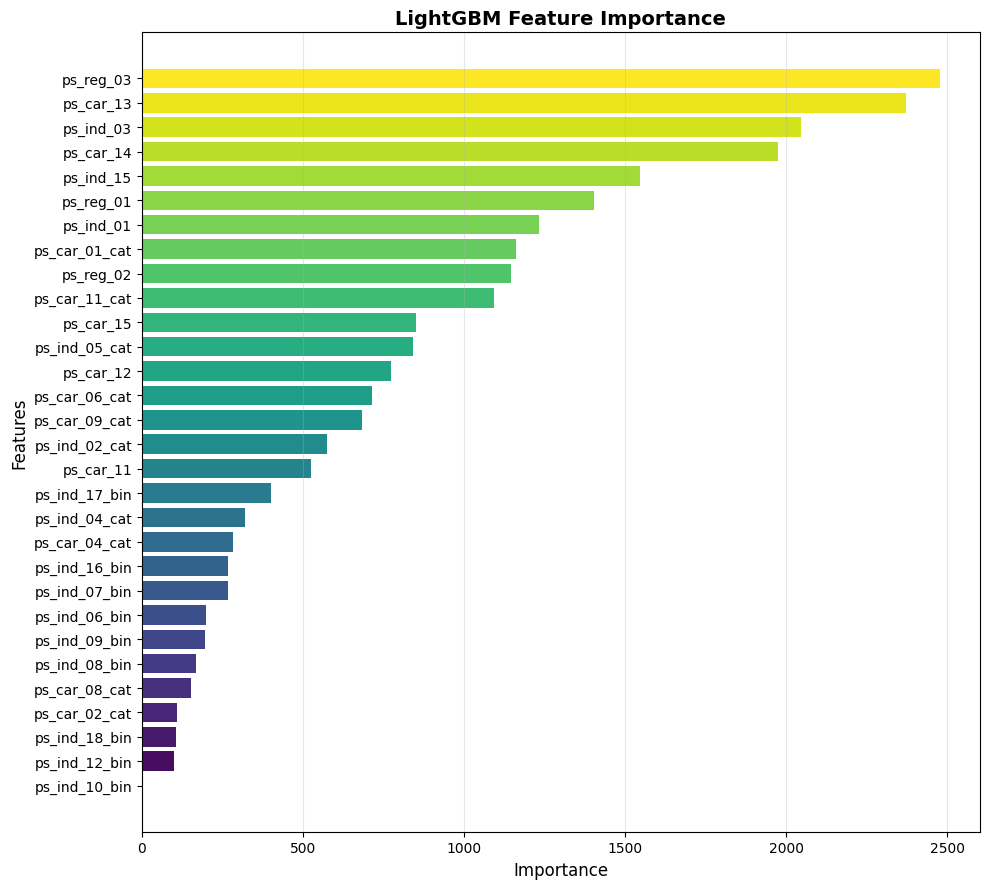

In [20]:
importance = lgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
})

feature_importance = feature_importance.sort_values('importance', ascending=True)

plt.figure(figsize=(10, max(6, len(X_train.columns) * 0.3)))

colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
bars = plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors)

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('LightGBM Feature Importance', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Kaggle Submission
We'll train on full data (Train.csv) and have the model predict the possibilities for kaggle submission (Test.csv).

In [21]:
data_train = pd.read_csv('../data/raw/Train.csv')
data_test = pd.read_csv('../data/raw/Test.csv')

data_train = data_train.replace(-1, np.nan)
data_test = data_test.replace(-1, np.nan)

y_test_id = data_test['id'].values

data_train = data_train.drop('id', axis=1)
data_test = data_test.drop('id', axis=1)

In [22]:
for col in cols_fillna_mode:
    mode = data_train[col].mode()[0]
    data_train[col] = data_train[col].fillna(mode)
    data_test[col] = data_test[col].fillna(mode)

for col in cols_fillna_median:
    median = data_train[col].median()
    data_train[col] = data_train[col].fillna(median)
    data_test[col] = data_test[col].fillna(median)

In [23]:
data_train = data_train.drop(drop_cols, axis=1)
data_test = data_test.drop(drop_cols, axis=1)

In [24]:
X_train = data_train.drop('target', axis=1)
y_train = data_train['target'].values

os.makedirs('../data/processed')
joblib.dump((X_train, y_train), '../data/processed/train_data.joblib')

X_test = data_test

In [25]:
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train, y_train)
y_test_scores = lgb_model.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 21694, number of negative: 573518
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 595212, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036448 -> initscore=-3.274754
[LightGBM] [Info] Start training from score -3.274754


In [26]:
submission_df = pd.DataFrame({
    'id': y_test_id,
    'target': y_test_scores
})

os.makedirs('../submission', exist_ok=True)
submission_df.to_csv('../submission/submission.csv', index=False, float_format='%.4f')